In [1]:
import multiprocess as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import requests
from urllib.parse import urlparse

In [2]:
basedir = './prepped_data/'

In [3]:
%%time
main_data_df = pd.read_csv(basedir + 'main_data_monthly_converted.csv')
print(main_data_df.shape)
main_data_df.head()

(4441027, 17)
Wall time: 9.28 s


,전월세매매구분,전용면적(㎡),계약일,금액(만원),층,건축년도,가격/면적,년,월,target_log_transformed,target/area_log_transformed,건물종류,지번주소,도로명주소,X좌표,Y좌표,주택가격지수
0,매매,77.75,8,57000.0,2,1988,733.118971,2013,9,10.950807,6.597308,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,79.100
1,매매,77.75,16,57000.0,2,1988,733.118971,2013,12,10.950807,6.597308,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,79.213
2,매매,77.75,29,55000.0,7,1988,707.395498,2014,1,10.915088,6.561590,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,79.451
3,매매,77.75,10,59500.0,4,1988,765.273312,2014,11,10.993732,6.640233,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,82.100
4,매매,77.75,28,75000.0,5,1988,964.630225,2016,3,11.225243,6.871745,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,89.466


In [4]:
main_data_df['가격/면적'] = main_data_df['금액(만원)'] / main_data_df['전용면적(㎡)']

<AxesSubplot:>

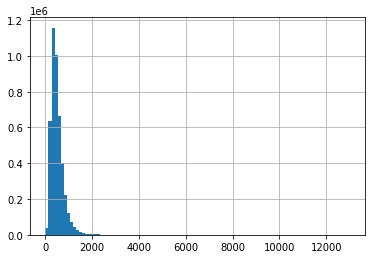

In [5]:
main_data_df['가격/면적'].hist(bins=100)

<AxesSubplot:>

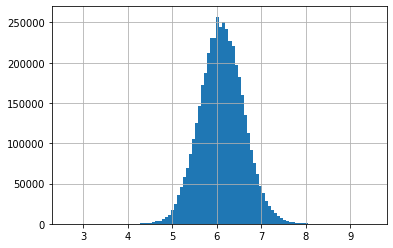

In [6]:
main_data_df['가격/면적'].apply(np.log).hist(bins=100)

In [7]:
%%time
land_prices_df = pd.read_csv(basedir + 'land_prices_ver_2.csv')
land_prices_df.shape

Wall time: 834 ms


(1594565, 4)

In [8]:
%%time
land_specs_df = pd.read_csv(basedir + 'land_specs_ver_3.csv')
land_specs_df.shape

Wall time: 2.27 s


(1563645, 11)

In [9]:
%%time
land_plans_df = pd.read_csv(basedir + 'land_plans_ver_3.csv')
land_plans_df.shape

<string>:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,27

Wall time: 29.9 s


(1565190, 288)

In [10]:
land_plans_df.fillna('해당사항없음', inplace=True)

In [11]:
main_data_df.rename(columns={'전용면적(㎡)':'전용면적'}, inplace=True)

In [12]:
main_data_df['year_linear'] = (main_data_df['년'] - main_data_df['년'].min()) + ((main_data_df['월']-1)/12)

In [13]:
def month_circular_sine_func(x):
    return math.sin(2*math.pi*((x-1)/12))

def month_circular_cosine_func(x):
    return math.cos(2*math.pi*((x-1)/12))

In [14]:
main_data_df['month_sin'] = main_data_df['월'].apply(month_circular_sine_func)
main_data_df['month_cos'] = main_data_df['월'].apply(month_circular_cosine_func)

In [15]:
main_data_df.drop(columns=['월', '계약일'], inplace=True)

In [16]:
xmax = main_data_df['X좌표'].max()
xmin = main_data_df['X좌표'].min()
ymax = main_data_df['Y좌표'].max()
ymin = main_data_df['Y좌표'].min()

In [17]:
coor_minmax_df = pd.DataFrame({'xmax':xmax, 'xmin':xmin, 'ymax':ymax, 'ymin':ymin}, index=[0])
coor_minmax_df.to_csv('./Training/training_data_ver_17/coor_minmax.csv', index=False)
coor_minmax_df

,xmax,xmin,ymax,ymin
0,971728.508488,938060.786948,1.965830e+06,1.937374e+06


In [18]:
main_data_df['xnorm'] = (main_data_df['X좌표'] - xmin - ((xmax - xmin)/2))
main_data_df['ynorm'] = (main_data_df['Y좌표'] - ymin - ((ymax - ymin)/2))
main_data_df['x_2nd'] = main_data_df['xnorm']**2 / 2
main_data_df['y_2nd'] = main_data_df['ynorm']**2 / 2
main_data_df['x_sin'] = main_data_df['xnorm'].apply(np.sin)
main_data_df['y_sin'] = main_data_df['ynorm'].apply(np.sin)
main_data_df['x_cos'] = main_data_df['xnorm'].apply(np.cos)
main_data_df['y_cos'] = main_data_df['ynorm'].apply(np.cos)
main_data_df['xy'] = main_data_df['xnorm'] * main_data_df['ynorm']

In [19]:
main_data_df.drop(columns=['X좌표', 'Y좌표'], inplace=True)

In [20]:
main_data_df['trade_type'] = main_data_df['건물종류'] + '_' + main_data_df['전월세매매구분']
main_data_df.drop(columns=['건물종류', '전월세매매구분'], inplace=True)

In [21]:
merge1_df = main_data_df.merge(land_prices_df, on=['지번주소', '년'])
merge1_df.shape

(4280322, 26)

In [22]:
merge1_df['공시지가'] = merge1_df['공시지가'] / 10000
merge1_df.rename(columns={'공시지가':'공시지가(만원)'}, inplace=True)

In [23]:
cols = [col for col in land_specs_df.columns if col != '공시지가']
cols

['지번주소',
 '년',
 '지목명',
 '토지면적',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [24]:
merge2_df = merge1_df.merge(land_specs_df[cols], on=['지번주소', '년'])
merge2_df.shape

(4279498, 34)

In [25]:
merge3_df = merge2_df.merge(land_plans_df, on=['지번주소', '년'])
merge3_df.shape

(4277252, 320)

In [26]:
merge3_df.columns = [col.replace(':','_').replace('/','_').replace('\\','_').replace('*','_').replace('?','_')\
                         .replace('\"','_').replace('|','_').replace('<','_').replace('>','_').replace('ㆍ','_')\
                         .replace(' ','_').replace('·','_').replace('-','_').replace('~','_')\
                         for col in merge3_df.columns]

In [27]:
land_plans_df.columns = [col.replace(':','_').replace('/','_').replace('\\','_').replace('*','_').replace('?','_')\
                         .replace('\"','_').replace('|','_').replace('<','_').replace('>','_').replace('ㆍ','_')\
                         .replace(' ','_').replace('·','_').replace('-','_').replace('~','_')\
                         for col in land_plans_df.columns]

In [28]:
lp_catcols = land_plans_df.columns.tolist()[2:]
lp_catcols[:5]

['(한강)오염행위_제한지역', '(한강)폐기물매립시설_설치제한지역', '4대문안', '가로구역별_최고높이_제한지역', '가스공급설비']

In [29]:
ls_catcols = [col for col in cols if col not in ['지번주소', '년', '토지면적']]
ls_catcols

['지목명', '용도지역명1', '용도지역명2', '토지이동상황', '지형높이', '지형형상', '도로접면']

In [30]:
merge3_df.drop(columns=['년', '도로명주소'], inplace=True)

In [32]:
merge3_df.head()

,전용면적,금액(만원),층,건축년도,가격_면적,target_log_transformed,target_area_log_transformed,지번주소,주택가격지수,year_linear,month_sin,month_cos,xnorm,ynorm,x_2nd,y_2nd,x_sin,y_sin,x_cos,y_cos,xy,trade_type,공시지가(만원),표준지여부,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,(한강)오염행위_제한지역,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가_착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고도지구,고등학교,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공동구,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M_70M),광로3류(폭_40M_50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통및공급시설,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도_54_236m),대공방어협조구역(위탁고도_77_257m),대로1류(폭_35M_40M),대로2류(폭_30M_35M),대로3류(폭_25M_30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,묘지공원,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,박물관,방송통신시설,방수설비,방재지구,방화지구,변전소(전원개발사업구역),변전시설,보전산지,보전임지,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,소공원,소로1류(폭_10M_12M),소로2류(폭_8M_10M),소로3류(폭_8M_미만),소하천,소하천구역,수도공급시설,수평표면구역,시_도_생태_경관보전지역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,아파트지구,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,완충녹지,용도구역기타,용도구역미분류,운동장,원추표면구역,원형보존지,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차전용도로,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(전술항공_5km),제한보호구역(후방지역_500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합의료시설,주간선도로,주거용지,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M_25M),중로2류(폭_15M_20M),중로3류(폭_12M_15M),중심대광장,중심상업지역,중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,철도,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,통제보호구역,통제보호구역(민통선이남_300m),특수도로(보행자전용도로),특정개발진흥지구,특화경관지구,폐기물처리및재활용시설,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,학교,학교시설보호지구,학교이적지,학교환경위생_정화구역,현상변경허가_대상구역,홍수관리구역
0,77.75,57000.0,2,1988,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2,79.100,7.666667,-0.866025,-0.500000,5579.095707,-9048.956121,1.556315e+07,4.094180e+07,-0.364267,-0.920469,0.931294,0.390815,-5.048499e+07,아파트_매매,921.0,N,대,1168.3,제3종일반주거지역,지정되지않음,아파트,평지,세로장방,광대세각,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,포함,해당사항없음,접함,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,포함,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,접함,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,포함,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,포함,포함,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,해당사항없음,

In [31]:
lp_map_df = pd.read_csv('./토지이용계획정보/feature_map.csv')
print(lp_map_df.shape)
lp_map_df

(4, 2)


,value,map
0,해당사항없음,0
1,포함,1
2,저촉,2
3,접함,3


In [33]:
lp_map = {}
for i in range(lp_map_df.shape[0]):
    lp_map[lp_map_df['value'][i]] = lp_map_df['map'][i]

In [34]:
lp_map

{'해당사항없음': 0, '포함': 1, '저촉': 2, '접함': 3}

In [35]:
for col in tqdm(lp_catcols):
    merge3_df[col] = merge3_df[col].map(lp_map)

100%|████████████████████████████████████████████████████████████████████████████████| 286/286 [09:37<00:00,  2.02s/it]


In [36]:
cat_cols = ['trade_type', '표준지여부'] + ls_catcols

In [37]:
for col in tqdm(cat_cols):
    col_map = {}
    col_map_df = pd.DataFrame({'cat':merge3_df[col].unique(),'map':[i for i in range(len(merge3_df[col].unique()))]})
    for i in range(col_map_df.shape[0]):
        col_map[col_map_df['cat'][i]] = col_map_df['map'][i]
    merge3_df[col] = merge3_df[col].map(col_map)
    col_map_df.to_csv('./Training/training_data_ver_17/feature_maps/{}_map.csv'.format(col))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.60it/s]


In [38]:
cols_to_drop = []
for col in tqdm(merge3_df.columns):
    try:
        if merge3_df[col].std() == 0:
            cols_to_drop.append(col)
        else:
            pass
    except:
        pass

100%|████████████████████████████████████████████████████████████████████████████████| 318/318 [00:12<00:00, 25.38it/s]


In [39]:
len(cols_to_drop)

0

In [40]:
cols_to_drop

[]

In [41]:
merge3_df = merge3_df.drop(columns=cols_to_drop)

In [42]:
%%time
merge3_df.to_csv('./Training/training_data_ver_17/training_data_ver_17_nocut.csv', index=False)

Wall time: 2min 28s


In [43]:
merge3_df.shape

(4277252, 318)

In [44]:
for col in cols_to_drop:
    if col in cat_cols:
        cat_cols.remove(col)

In [45]:
cat_cols_df = pd.DataFrame({'colname':cat_cols})
print(cat_cols_df.shape)
cat_cols_df.head()

(9, 1)


,colname
0,trade_type
1,표준지여부
2,지목명
3,용도지역명1
4,용도지역명2


In [46]:
cat_cols_df.to_csv('./Training/training_data_ver_17/cat_cols.csv', index=False)